In [12]:
import copy
import json

import gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sys
sys.path.append('../')
from src.approx import PolyFeatures
from src.models import EnvModel, ModelWrapper
from src.qlearning import Qlearner
from src.util import evaluate
from src.util import run_learner, smooth, plot_mc_value, generate_data
%matplotlib inline

# Environment

We create a custom MountainCar version that increases the time limit per episode to 5000 steps. This makes solving the environment slightly easier.

In [7]:
env = gym.make('MountainCarLong-v0')
eval_env = copy.deepcopy(env) # create a separate environment to run evaluations on


# Model- free Learner

Create a linear Q-learner. This Q-learning agent uses linear function approximation with polynomial features to approximate the value function.

In [8]:
# Create 5th degree polynomial features
feature_map = PolyFeatures(env, 5)
qlearner = Qlearner(feature_map, n_actions = env.action_space.n, lr=0.05, discount=0.99, eps=0.1)

Solve the environment: 

In [ ]:
mf_log = run_learner(env, qlearner, 500, eval_env, log_steps=1000)

In [46]:
with open('../data/model_free.json', 'w') as f:
    json.dump(mf_log, f)

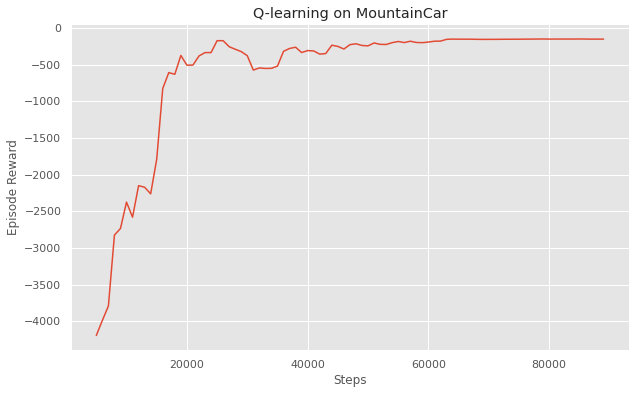

In [18]:
plt.style.use('ggplot')

plt.figure(figsize=(10,6))
plt.title('Q-learning on MountainCar')
plt.xlabel('Steps')
plt.ylabel('Episode Reward')
plt.plot(mf_log['steps'][4:], smooth(mf_log['rewards'],5), label='model-free') # smooth by plotting running average
plt.savefig('../images/qlearning.png')

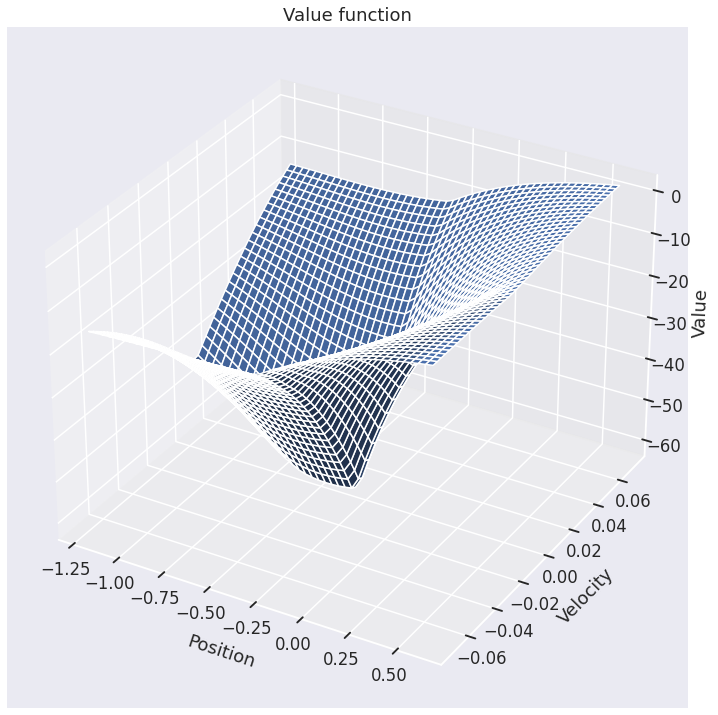

In [36]:
fig = plt.figure(figsize=(10,11))
ax=plot_mc_value(env.observation_space, qlearner.phi, qlearner.weights, fig)
ax.set_title('Value function')
plt.xlabel("Position", labelpad=15)
plt.ylabel("Velocity", labelpad=15)
ax.set_zlabel("Value", labelpad=10)
plt.tight_layout()
plt.savefig('../images/vfun.png', transparent=True)

# Model Based Learning

In [14]:
def run_model_based(real_env, max_data):
    log = {
        'nsamples': [],
        'model_reward': [],
        'env_reward': [],
        'model_error': []
    }
    test_set = generate_data(env, 10000, lambda s: real_env.action_space.sample())
    test_states, test_actions, test_rewards, test_nstates, test_done = tuple(map(np.array, zip(*test_set)))
    for n_samples in range(1000, max_data, 1000):
        # generate data and train model
        train_set = generate_data(real_env, n_samples, lambda s: real_env.action_space.sample())
        states, actions, rewards, nstates, done = tuple(map(np.array, zip(*train_set)))
        feature_map = PolyFeatures(env, 5)
        model = EnvModel(feature_map)
        model.train(states, actions, rewards, nstates)
        # wrap model in gym interface and train qlearner on model environment
        model_env = ModelWrapper(model)
        mb_qlearner = Qlearner(feature_map, n_actions = real_env.action_space.n, lr=0.05, discount=0.99, eps=0.1)
        run_learner(model_env, mb_qlearner, 500, real_env, log_steps=-1)
        # evaluate trained learner on model env
        model_reward = evaluate(model_env, mb_qlearner, 10)[-1]
        # evaluate trained learner on real env
        reward = evaluate(real_env, mb_qlearner, 10)[-1]
        log['nsamples'].append(n_samples)
        log['model_reward'].append(model_reward)
        log['env_reward'].append(reward)
        log['model_error'].append(float(np.mean((model.predict(test_states, test_actions)[0] - test_nstates)**2)))
    return log

Run model-based learning. This will take a long time. For each number of steps we train a new model, run 500 episodes of model-free Q-learning training on the model, then evaluate.

In [ ]:
mb_log = run_model_based(eval_env, 20000)

In [55]:
with open('../data/model_based.json', 'w') as f:
    json.dump(mb_log, f)

In [16]:
with open('../data/model_based.json', 'r') as f:
    mb_log_copy = json.load(f)

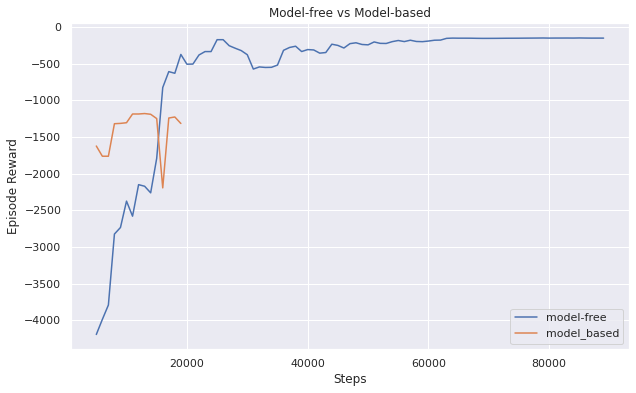

In [17]:
plt.figure(figsize=(10,6))
plt.title('Model-free vs Model-based')
plt.xlabel('Steps')
plt.ylabel('Episode Reward')
plt.plot(mf_log['steps'][4:], smooth(mf_log['rewards'],5), label='model-free')
plt.plot(mb_log_copy['nsamples'][4:], smooth(mb_log_copy['env_reward'],5), label='model_based')
plt.legend()
#plt.savefig('../images/mfvsmb2.png')

# Evaluate the model

Plot the test error on 1-step predictions. This shows how well the model predicts 1 step in the future on randomly sampled states:

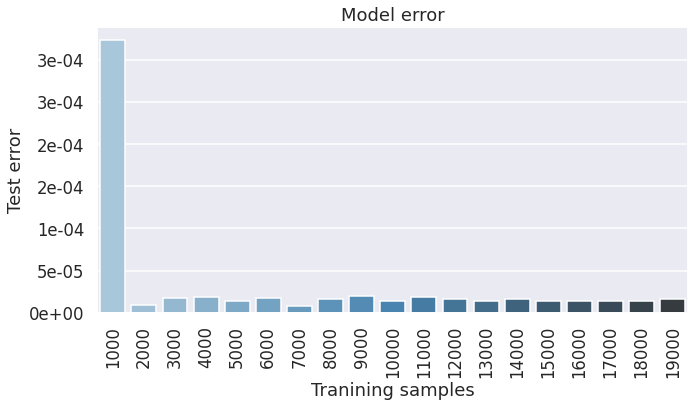

In [74]:
import matplotlib.ticker as ticker

mb_log_copy2['nsamples'] = list(map(int, mb_log_copy2['nsamples']))
plt.figure(figsize=(10,6))
ax =sns.barplot(x="nsamples", y="model_error", data=mb_log_copy2, palette="Blues_d")
plt.title('Model error')
plt.xlabel('Tranining samples')
plt.ylabel('Test error')

plt.xticks(rotation=90)
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
plt.tight_layout()
plt.savefig('../images/model_err.png', transparent=True)

Train a model to evalute performance

In [76]:
n_samples = 5000  # should be fine according to plot above
train_set = generate_data(env, n_samples, lambda s: env.action_space.sample())
test_set = generate_data(eval_env, n_samples, lambda s: env.action_space.sample())

states, actions, rewards, nstates, done = tuple(map(np.array, zip(*train_set)))
feature_map = PolyFeatures(env, 5)
model = EnvModel(feature_map)
model.train(states, actions, rewards, nstates)


Check the model prediction error

In [77]:
test_states, test_actions, test_rewards, test_nstates, test_done = tuple(map(np.array, zip(*test_set)))
print(f"Model 1-step predition error {np.mean((model.predict(test_states, test_actions)[0] - test_nstates)**2)}")

Model 1-step predition error 3.51835842593573e-05


Now see what happens when we try to predict multiple steps into the future

In [171]:
horizon_length = 100
actions = [eval_env.action_space.sample() for _ in range(horizon_length)]
start_state = eval_env.reset()
real_states = [start_state] + [eval_env.step(a)[0] for a in actions]
model_states = [start_state.copy()]
for a in actions:
    model_states.append(model.predict(model_states[-1], a)[0][0])

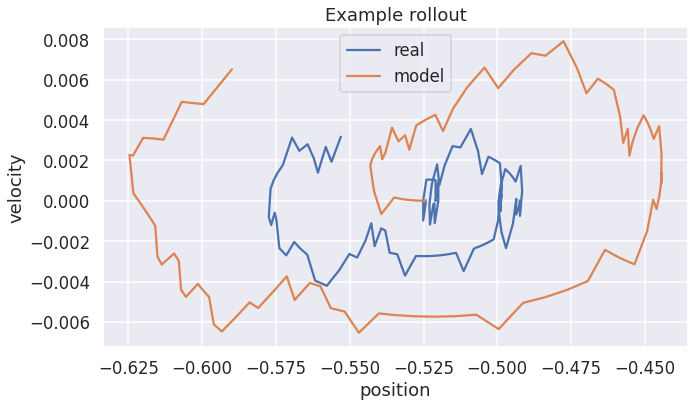

In [173]:
real_states =np.array(real_states)
model_states =np.array(model_states)

plt.figure(figsize=(10,6))
plt.plot(real_states[:,0], real_states[:,1], label='real')
plt.plot(model_states[:,0], model_states[:,1], label='model')
plt.title('Example rollout')
plt.xlabel('position')
plt.ylabel('velocity')
plt.legend()
plt.tight_layout()
plt.savefig('../images/rollout.png', transparent=True)

In [116]:
# repeat experiment for several random action sequences
results = []

for rep in range(100):
    actions = [eval_env.action_space.sample() for _ in range(50)]
    start_state = eval_env.reset()
    real_states = [start_state] + [eval_env.step(a)[0] for a in actions]
    model_states = [start_state.copy()]
    for a in actions:
        model_states.append(model.predict(model_states[-1], a)[0][0])
    results.append(np.mean((np.array(real_states) - np.array(model_states))**2.,axis=-1))
results = np.array(results)

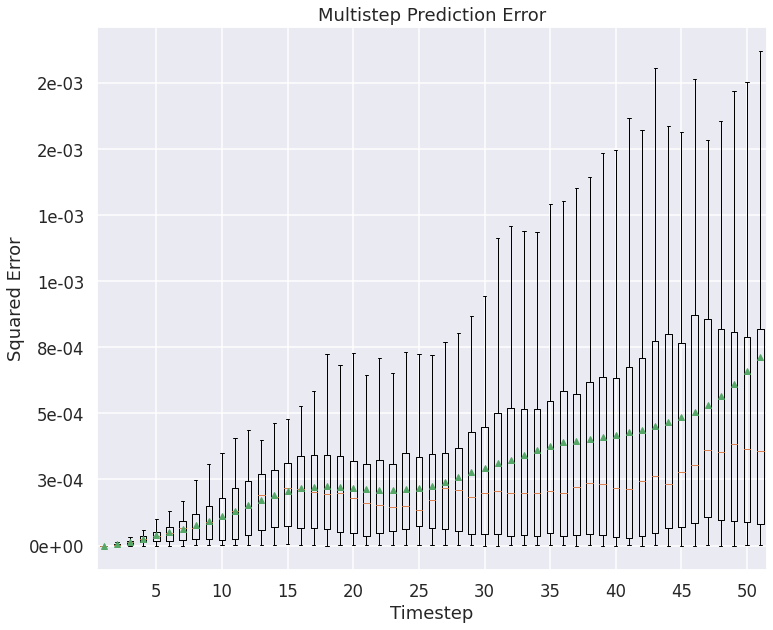

In [142]:
plt.figure(figsize=(12,10))
plt.title('Multistep Prediction Error')
_ = plt.boxplot(results, showfliers=False, showmeans=True)
plt.xlabel('Timestep')
plt.ylabel('Squared Error')
_=plt.xticks(np.arange(5,51,5), np.arange(5,51,5))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
plt.savefig('../images/rollout_err.png', transparent=True)

Visualize policy shift:

In [193]:
random_policy_states =  tuple(map(np.array, zip(*generate_data(eval_env, 50000, lambda s: env.action_space.sample()))))[0]
trained_policy_states =tuple(map(np.array, zip(*generate_data(eval_env, 50000, qlearner.select_action))))[0]

/imec/other/nmorph/vrancx22/private/anaconda3/envs/ml4coo/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  from ipykernel import kernelapp as app


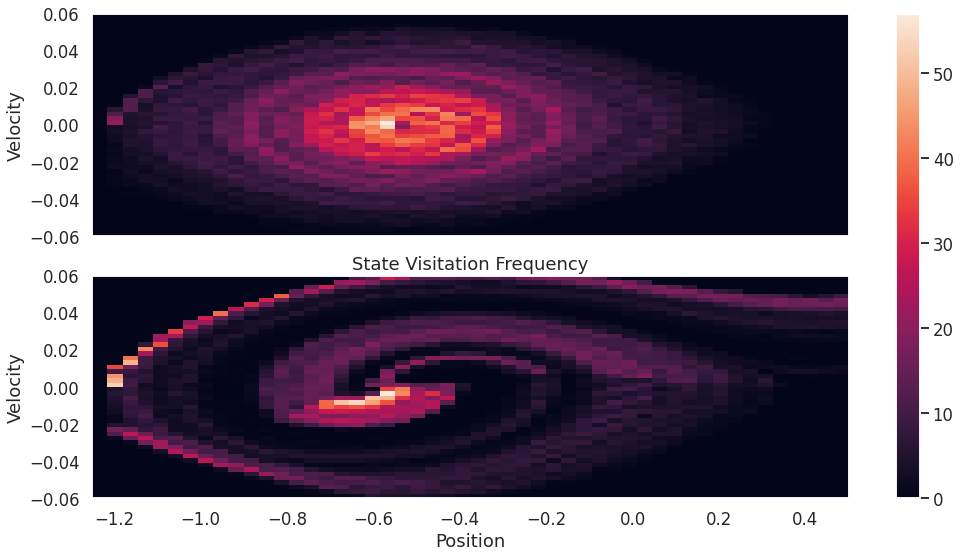

In [227]:
f, (ax1 , ax2) = plt.subplots(2, sharex=True, figsize=(15,8))
plt.grid(False)
ax1.grid(False)
ax2.grid(False)

plt.title('State Visitation Frequency')
ax1.set_ylabel('Velocity')
ax2.set_ylabel('Velocity')
ax2.set_xlabel('Position')

ax1.hist2d(random_policy_states[:,0], random_policy_states[:,1],  range=[[-1.25, 0.5], [-0.06, 0.06]], density=True, bins=50)
im=ax2.hist2d(trained_policy_states[:,0], trained_policy_states[:,1], range=[[-1.25, 0.5], [-0.06, 0.06]], density=True, bins=50)
plt.setp((ax1 , ax2), xlim=(-1.25,0.5), ylim=(-0.06,0.06))
plt.tight_layout()
plt.colorbar(im[3],ax=[ax1, ax2])

plt.savefig('../images/state_visit.png', transparent=True)

# Adaptive planning with a model

Simplest possible open-loop planner: random shooting. Generate random action sequences, evaluate using model, keep the best one.

In [181]:
def random_shooting(start_state, n_acts, horizon, n_steps, eval_fun):
    best = -np.inf
    best_acts = []
    for _ in range(n_steps):
        acts = np.random.randint(n_acts, size=horizon)
        score = eval_fun(start_state, acts)
        if score > best:
            best, best_acts = score, acts
    return best_acts

Function to evaluate action sequence using an environment model. Note: we cheat by using a more informative reward signal (total energy of final state)

In [182]:
def create_mc_eval(model):
    def mc_eval(start_state, actions):
        state = start_state
        for a in actions:
            state = model.predict(state, a)[0][0]
        # cheating: use total energy of state much more informative than reward
        return np.sin(3*state[0]) + state[1] ** 2.
    return mc_eval

MPC turns simple open-loop planner into close loop adaptive planning. Only execute first action. Replan from next state.

In [185]:
def mpc(env, model, max_steps = 500):
    state = env.reset()
    eval_fun = create_mc_eval(model)
    for _ in range(max_steps):
        action = random_shooting(state, 3, 10, 20, eval_fun)[0]
        state, reward, done, _  = env.step(action)
        if done:
            print('done')
            break


Record movie:

In [189]:
from gym import wrappers

monitored_env = wrappers.Monitor(eval_env, "../images/mc")
mpc(monitored_env, model)
monitored_env.close()

done
